# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*.  
Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75.  
Проверьте *accuracy* на тестовой выборке самостоятельно.  

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data['messages'] = data['messages'].astype('int')

In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


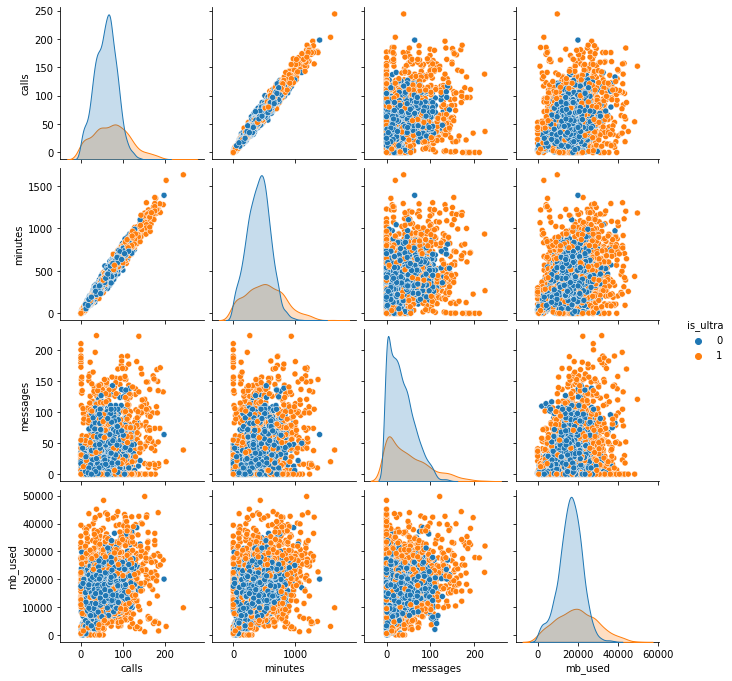

In [6]:
sns.pairplot(data, height=2.4, hue='is_ultra')
plt.show()

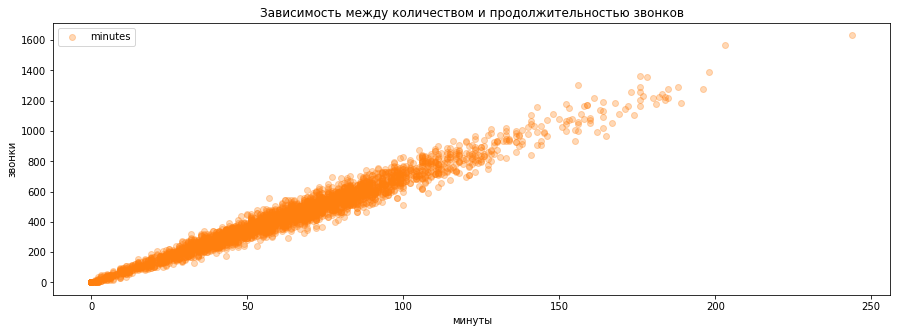

In [7]:
data.plot(x='calls', y='minutes', style='o', figsize=(15, 5), c='#FF7F0E', alpha=0.3)
plt.title("Зависимость между количеством и продолжительностью звонков")
plt.xlabel("минуты")
plt.ylabel("звонки")
plt.show()

In [8]:
def chaddock(ratio):
    chaddock_scale = {
        'очень слабая': (0, 0.3),
        'слабая': (0.3, 0.5),
        'средняя': (0.5, 0.7),
        'высокая': (0.7, 0.9),
        'очень высокая': (0.9, 1.0),
    }
    for k, v in chaddock_scale.items():
        if min(v) <= abs(ratio) < max(v):
            return k
    return None

k = data['calls'].corr(data['minutes'])
print(f'Корреляция между количеством и продолжительностью звонков: {k:.1%} ({chaddock(k)})')

Корреляция между количеством и продолжительностью звонков: 98.2% (очень высокая)


Уберу признак, который оказывает сильное влияние.

In [9]:
data.drop(['calls'], axis='columns', inplace=True)

***
### Вывод

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Столбец `messages` привёл к типу `integer`.<br><br>
***

## Разбейте данные на выборки

In [10]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

features_train, features_test_valid, target_train, target_test_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_test_valid, test_size=0.50, random_state=12345
)

In [11]:
print('Разделение выборки в следующих пропорциях:')
print(f'{(len(features_train)/len(data)):.0%} — тренировочная;')
print(f'{(len(features_test)/len(data)):.0%} — тестовая;')
print(f'{(len(features_valid)/len(data)):.0%} — валидационная.')

Разделение выборки в следующих пропорциях:
60% — тренировочная;
20% — тестовая;
20% — валидационная.


***
### Вывод

Разделил выборку на три группы: тренировочная, тестовая, валидационная.<br><br>
***

## Исследуйте модели

### Модель «Дерево решений»

In [12]:
best_model = None
best_accuracy = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
print(f"Наибольшая доля правильных ответов: {best_accuracy:.1%}, глубина «дерева»: {best_depth}")

Наибольшая доля правильных ответов: 78.8%, глубина «дерева»: 5


### Модель «Случайный лес»

In [13]:
best_model = None
best_accuracy = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth
            best_est = est
print(f"Наибольшая доля правильных ответов: {best_accuracy:.1%},\nколичество «деревьев»: {best_est}, глубина «дерева»: {best_depth}")

Наибольшая доля правильных ответов: 80.9%,
количество «деревьев»: 10, глубина «дерева»: 8


### Модель «Логистическая регрессия»

In [14]:
model = LogisticRegression(solver='liblinear')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions_valid)
print(f"Доля правильных ответов: {accuracy:.1%}")

Доля правильных ответов: 69.8%


***
### Вывод

Протестировал три модели: «Дерево решений», «Случайный лес», «Логистическая регрессия».  
Лучший результат — `81,3%` (`80,9%`, если убрать влияющий признак) — у двух из них: «Случайный лес», «Логистическая регрессия».<br><br>
***

## Проверьте модель на тестовой выборке

Объединение тренировочной и валидной выборки для окончательного обучения.  
Так доля правильных ответов выше.  

In [15]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [16]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=10)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print(f"Доля правильных ответов: {accuracy:.1%}")

Доля правильных ответов: 79.8%


Случайным образом выяснилось, что при количестве «деревьев» равным 40 и глубине равной 10  
доля правильных ответов выше.  

***
### Вывод

Доля правильных ответов — `80,7%` (`79.8%`, если убрать влияющий признак) — выше порогового значения 75%.<br><br>
***

## (бонус) Проверьте модели на адекватность

In [17]:
dummy_model = DummyClassifier()
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_dummy)
print(f"Доля правильных ответов: {accuracy:.1%}")

Доля правильных ответов: 70.6%


***
### Вывод

Доля правильных ответов модели, которая игнорирует входные параметры,  
меньше доли правильных ответов выбранной модели.  
Выбранная модель прошла проверку на адекватность.<br><br>
***